In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
torch.cuda.empty_cache()
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer   # for tokenization
from collections import Counter     # for tokenizer

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
# import matplotlib.image as Image
import PIL
from PIL import Image

# for the bleu scores
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from main import *
from model_attention import EncoderDecoder
from model_baseline import CNNToRNN

In [2]:
# Getting CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device :-", device)

Using device :- cuda:0


In [3]:
CAPTIONS_PATH = "Flickr8k/captions.txt"
IMAGES_PATH = "Flickr8k/Images/"

In [4]:
transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(384),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = customDataset(
    image_dir = IMAGES_PATH,
    captions_file = CAPTIONS_PATH,
    transform = transforms
)

In [5]:
with open('vocab.pkl', 'wb') as file:
    pickle.dump(dataset.vocab, file)

In [6]:
validation_split = .1
shuffle_dataset = False
random_seed= 42

In [7]:
batch_size = 8
val_ratio = 0.1
train_loader,validator_loader = train_val_split(dataset,val_ratio,batch_size)

In [8]:
# Initializing Variable for attention model
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 128
enc_dim = 2048
dec_dim = 256
learning_rate = 3e-4

model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [9]:
# # Initializing Variable for baseline model
# embed_size = 256
# hidden_size = 256
# num_layers = 5
# learning_rate = 3e-4
# vocab_sz = len(dataset.vocab)

# model = CNNToRNN(
#     embed_size=embed_size,
#     hidden_size=hidden_size,
#     vocab_size=vocab_sz,
#     num_layers=num_layers
# ).to(device)

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.sentenceToIndex["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1 loss: 5.17211
<start> a a a . <end>


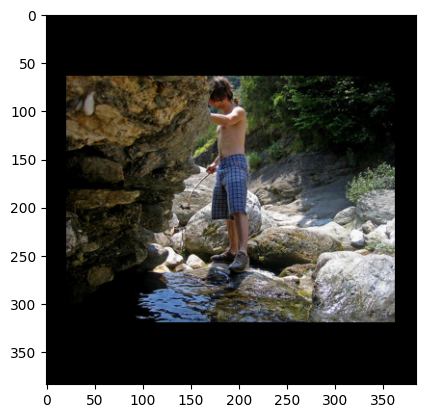

Epoch: 1 loss: 4.59044
<start> a man in a man in a . <end>


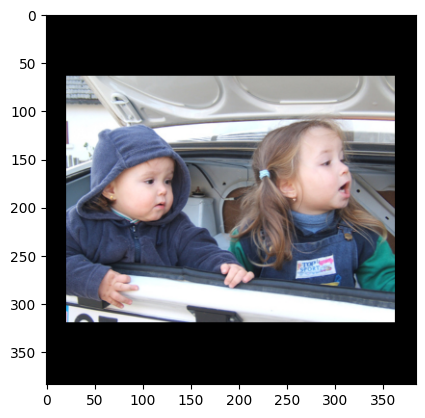

Epoch: 1 loss: 4.48921
<start> a man in a man in a man in a . <end>


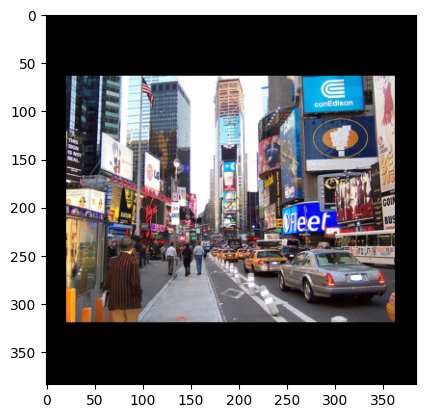

Epoch: 1 loss: 4.10242
<start> a man in a man in a red . <end>


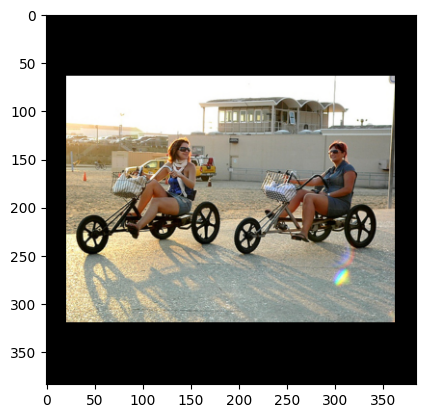

Epoch: 1 loss: 4.46609
<start> a man in a man in a red . <end>


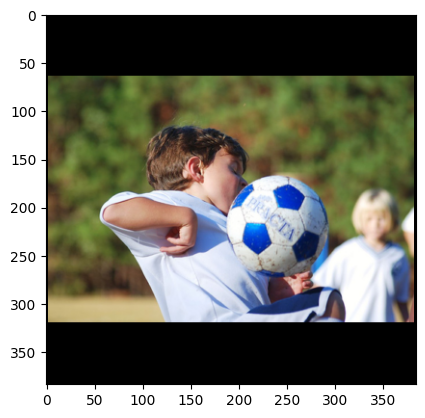

In [11]:
epochs = 1
print_each = 100
train(
    epochs=epochs,
    print_each=print_each,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dls=train_loader,
    vocab_sz=vocab_sz,
    validation_loader=validator_loader,
    dataset=dataset,
    device=device
)

In [ ]:
Model_path = './imageCaptioning.pth'
model = load_model(Model_path,model)
descriptors = getDescriptors(CAPTIONS_PATH)

y_true,y_pred,predicted_sentence = make_predictions(model,validator_loader,batch_size,dataset,descriptors,device)

In [ ]:
calc_BLEU_score(y_true,y_pred)

In [ ]:
calc_meteor_score(y_true,y_pred)